In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

In [34]:
def identity(x):
    return x

def relu(x):
    
    # One line return statement is dope!
    return np.where(x > 0, x, 0)

def l_relu(x, a = 0.01):
    
    # One line return statement is dope!
    return np.where(x > 0, x, a*x)

def natural_l_relu(x, a = 0.01, b = 0.9):
    return np.where(x > b, np.log(x), a * x)

def exp_relu(x, a = 0.4):
    return np.where(x > 0, np.power(x, a), -np.power(-x, a))

def sech(x):
    return 2 * np.exp(x)/(np.exp(2*x) + 1)

def sine(x):
    
    return np.sin(x)

def cos(x):
    
    return np.cos(x)

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1/(1+np.exp(-x))

c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


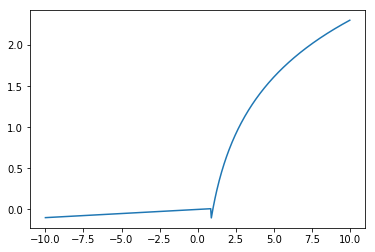

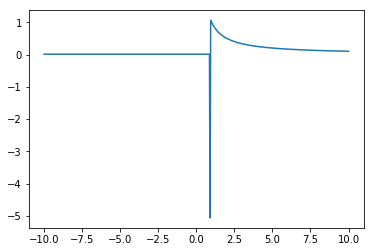

In [35]:
# Experimental: Yield the approximation of the derivative of function f at point x
def get_derivative(f, x, offset = 0.01):
    
    # Define points between which derivative is approximated
    vec1 = np.array([x - offset, f(x - offset)])
    vec2 = np.array([x + offset, f(x + offset)])
    
    # Get the vector between the two points
    sub = vec2 - vec1
    
    # Return the slope (rise over run echoes in your head)
    return sub[1]/sub[0]


activation = natural_l_relu
# Method used for mapping multiple values to the get_derivative method.
def test_approximation(x):
    return get_derivative(activation, x)
limit = 10
line = np.linspace(-limit, limit, num = 500)

plt.plot(line, list(map(activation, line)))
plt.show()
plt.plot(line, list(map(test_approximation, line)))
plt.show()

In [36]:
y_t = 10
def radial_basis_function(x, sig = 0.3):
    return np.exp(-np.power((np.abs(x - y_t) * sig), 2))

In [24]:
for i in range(10):
    y_t = i
    print(radial_basis_function(np.array([0])))

[           1.000]
[           0.914]
[           0.698]
[           0.445]
[           0.237]
[           0.105]
[           0.039]
[           0.012]
[           0.003]
[           0.001]


# Loss functions

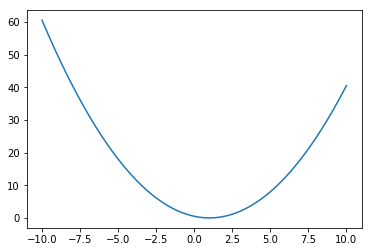

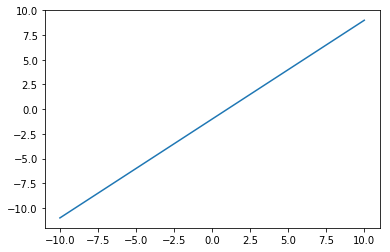

In [37]:
y_t = 3
l = 2

class MSE:
    def __init__(self):
        
        self.y_t = None
    def loss(self, y_p):

        error = np.square(y_p - self.y_t) * 1/(2 * y_p.size)
        return np.nan_to_num(error)
        
    def compute(self, y_p, y_t):
            
        self.y_t = y_t
            
        return self.loss(y_p)
    
    def derivative(self, x):
            
        return get_derivative(self.loss, x)
            
        
mse = MSE()
activation = mse.loss
mse.y_t = 1
plt.plot(line, list(map(activation, line)))
plt.show()
plt.plot(line, list(map(test_approximation, line)))
plt.show()

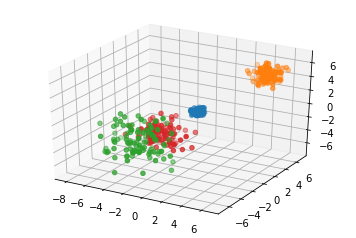

c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


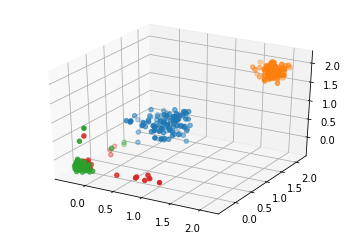

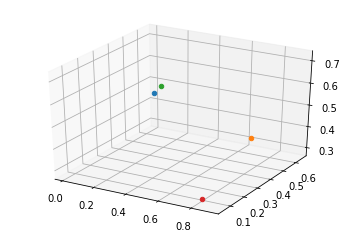

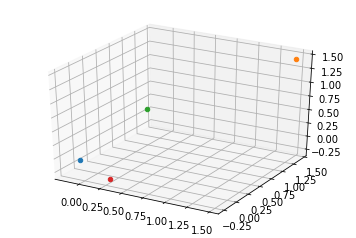

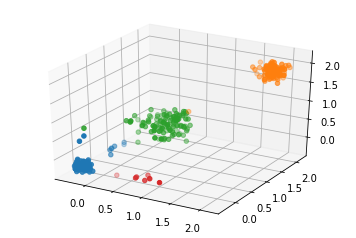

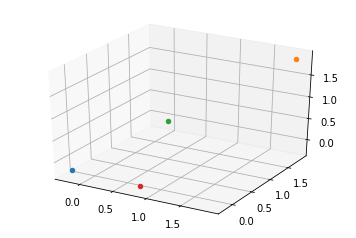

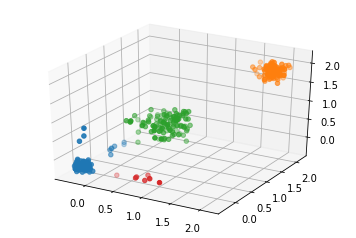

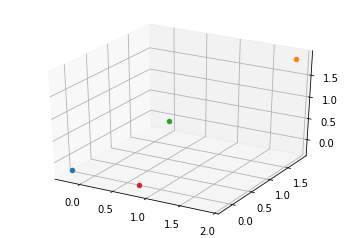

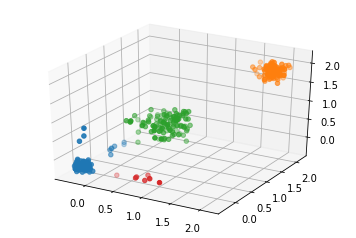

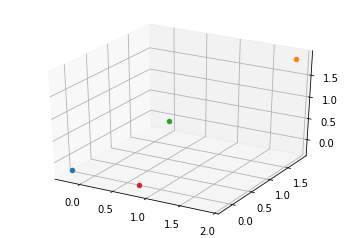

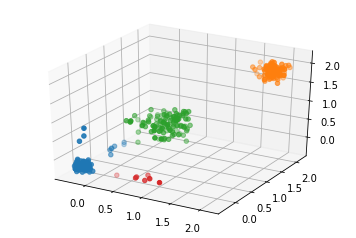

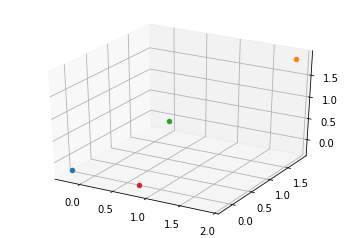

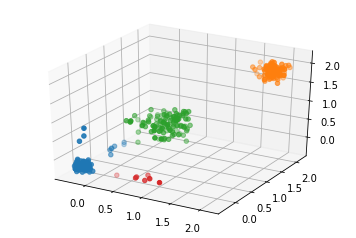

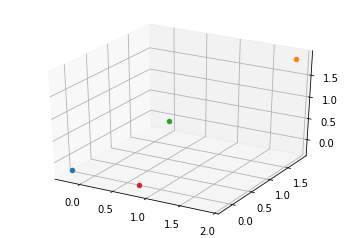

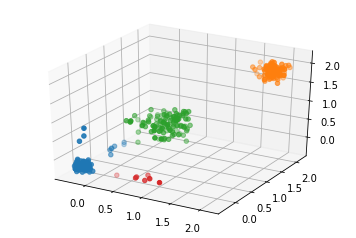

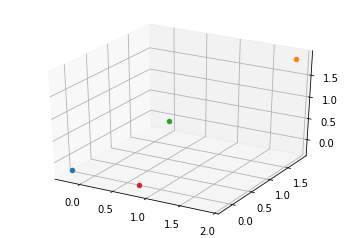

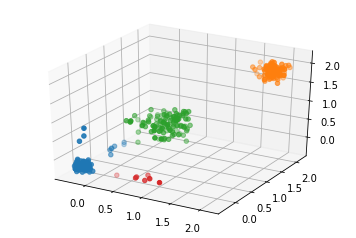

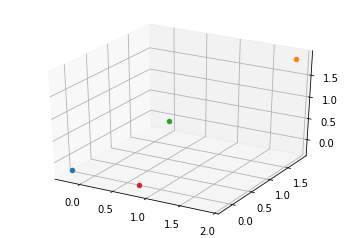

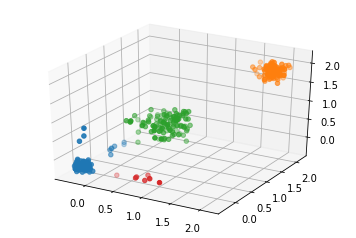

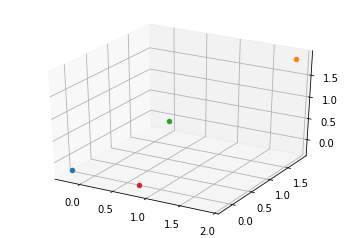

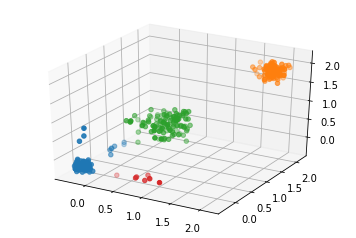

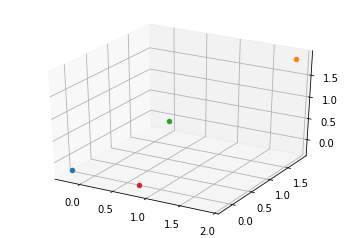

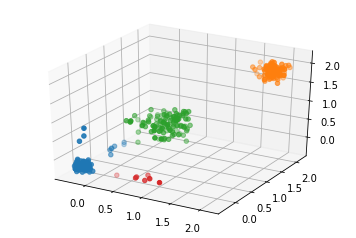

In [512]:
def k_medians(clusters, points, iters = 10, method = np.median):
    
    for i in range(iters):
        
        cluster_points = get_cluster_belonging(clusters, points)

        for c in range(len(clusters)):

            clusters[c] = method(cluster_points[c], axis = 0)
    
    return clusters

def get_cluster_belonging(clusters, points):
    cluster_points = [[] for i in range(len(clusters))]
    for e in points:

        minimum_distance = None

        cluster_dists = []

        for cluster in clusters:

            dist = np.sqrt(np.sum(np.power(cluster - e, 2)))
            #y_t = cluster
            #dist = radial_basis_function(cluster - e, sig = 10)
            #dist = np.sqrt(np.sum(np.power(dist, 2)))
            cluster_dists.append(dist)
        
        index = np.argmin(cluster_dists)

        cluster_points[index].append(e)
        
    return cluster_points

np.random.seed(0)
points = np.random.random_sample((100, 3))
points = np.vstack([points, np.random.normal(5, 0.7, size = (100, 3))])
points = np.vstack([points, np.random.normal(-3, 1.7, size = (100, 3))])
points = np.vstack([points, np.random.normal(1, 1.05, size = (100, 3))-3])

labels = np.ones(100) * 0
labels = np.hstack([labels, np.ones(100) * 1])
labels = np.hstack([labels, np.ones(100) * 2])
labels = np.hstack([labels, np.ones(100) * 3])

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = points[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()

#points = np.array(list(map(sigmoid, points)))
#points = np.array(list(map(exp_relu, points)))
points = np.array(list(map(l_relu, points)))
#points = np.array(list(map(tanh, points)))
points = np.array(list(map(exp_relu, points)))
#points = np.array(list(map(cos, points)))
#points = np.array(list(map(sine, points)))
#points = np.array(list(map(sech, points)))
#points = np.array(list(map(natural_l_relu, points)))

clusters = np.random.random_sample((4, 3))

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = points[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')

for c in clusters:
    ax.scatter(c[0], c[1], c[2])
plt.show()
    
for i in range(10):
    k_medians(clusters, points, iters = 1, method = np.mean)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for c in clusters:
        ax.scatter(c[0], c[1], c[2])
    plt.show()


    point_array = get_cluster_belonging(clusters, points)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for c in point_array:
        if len(c) > 0:
            ax.scatter(np.array(c).T[0], np.array(c).T[1], np.array(c).T[2])
    plt.show()


# Layer classes


In [252]:
# Super class of layers
class Layer(object):
    
    def __init__(self):
        
        self.signal = None
        self.derivative = None
        self.error = None
        self.gradient = []
        self.activation = identity
        
    def get_params(self):
        return None
        
    
class graph:
    
    def __init__(self, size, activation = identity, iters = 2, W = None):
        
        if W == None:
            size = (size, size + 1)
            self.W = np.random.random_sample(size) - 0.5
        else:
            self.W = W
        
        self.activation = activation
        self.iters = iters
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        self.signal = inp
        for i in range(self.iters):
            # Append bias
            inp = np.append(inp, 1)
            inp = self.activation(self.W.dot(inp))
        
        return inp
    
        
class scaling(Layer):
    def __init__(self, scalar = None):
        
        self.scalar = scalar
        
    def get_params(self):
        return self.scalar
    
    def feed_forward(self, inp, train = True):
            
        self.signal = inp
        if self.scalar == None:
            return inp * 1/np.max(np.abs(inp))
            
        return inp * self.scalar

In [743]:
class dropout:
    
    def __init__(self, rate = 0.1):
        
        self.rate = rate
        
        self.mask = None
        
    def get_params(self):
        return self.rate   
    
    def feed_forward(self, inp, train = True):
        
        self.signal = inp
        
        if train == False:
            return self.signal
    
        self.mask = np.random.random_sample(inp.shape)
        
        self.mask = np.where(self.mask > self.rate, 1, 0)
        
        return np.multiply(inp, self.mask)
    
    def compute_gradient(self, err):
        
        return err
    
    def update(self, alpha):
        return None

In [744]:
class leaky_relu(Layer):
    def __init__(self, size, a = None):
        
        if a == None:
            self.W = np.random.random_sample((size, 1))
        else:
            self.W = np.ones(size) * a
            
        def leaky_relu(x):
            ind = np.argwhere(x < 0)
            x[ind] = self.W.reshape(x.shape)[ind] * x[ind]
            signal = x
            
            return np.array(signal)
        
        self.gradients = []
        self.signal = None
        self.activation = leaky_relu
        
    def approximate_derivative(self, x):
        return get_derivative(self.activation, x)
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        self.signal = np.array(inp)
        if train:
            self.derivative = get_derivative(self.activation, self.signal)
            self.derivative = np.array(self.derivative).T
        
        return self.activation(inp)
    
    
    def compute_gradient(self, err):
        
        error = err.reshape(err.size, 1)
        
        # Derivative w.r.t. W
        derivative = np.where(self.signal > 0, 0, self.signal)
        
        # Gradient is used to update alpha value
        gradient = error * derivative.reshape(derivative.size, 1)

        # Error is use dto update layers after this
        error = error * self.derivative.reshape(self.derivative.size, 1)
        
        self.gradients.append(gradient)
        
        return (error)
        
    def update(self, alpha):
        for gradient in self.gradients:
            self.W += -alpha * gradient * 1/len(self.gradients)
            
        # Remember to reset gradient after update
        self.gradients = []

In [745]:
class normalization_layer(Layer):
    def __init__(self, W= None):
        
        if W== None:
            self.W = np.random.random_sample() * 0.01
        else:
            self.W = W
        
        def activation(x):
            return x * self.W
        
        self.gradients = []
        self.signal = None
        self.activation = activation
        
        
    def approximate_derivative(self, x):
        return get_derivative(self.activation, x)
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        self.signal = np.array(inp)
        
        if train:
            self.derivative = get_derivative(self.activation, self.signal)
            self.derivative = np.array(self.derivative).T
        
        return self.activation(inp)
    
    
    def compute_gradient(self, err):
        
        error = err.reshape(err.size, 1)
        
        # Derivative w.r.t. W
        derivative = np.ones(err.size) * self.signal
        
        # Gradient is used to update alpha value
        gradient = error * derivative.reshape(derivative.size, 1)
        gradient = np.mean(gradient)

        # Error is used to update layers after this
        error = error * self.derivative.reshape(self.derivative.size, 1)
        
        self.gradients.append(gradient)
        
        return (error)
        
    def update(self, alpha):
        for gradient in self.gradients:
            self.W += -alpha * gradient * 1/len(self.gradients)
            
        # Remember to reset gradient after update
        self.gradients = []

In [746]:
class fullyConnected(Layer):
    def __init__(self, size, activation = identity, W = None, standardize = False):
        
        if W == None:
            size = (size[0], size[1]+1)
            self.W = np.random.normal(loc = 0, scale = 2/(size[0] + size[1]+1), size = size)
            #self.W = np.random.random_sample(size) - 0.5
        else:
            self.W = W
        
        self.activation = activation
        
        self.gradients = []
        self.standardize = standardize
    
    def approximate_derivative(self, x):
        return get_derivative(self.activation, x)
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        # Append bias
        inp = np.append(inp, 1)
        
        self.signal = inp
        
        if train:
            self.derivative = get_derivative(self.activation, self.W.dot(inp))
            self.derivative = np.array(self.derivative).T
        
        return self.activation(self.W.dot(inp))
    
    
    def compute_gradient(self, err):
        """ old
        
        # error gradient next layer
        error = err.reshape(len(err), 1)
        
        #error = error * self.W
        
        # Error w.r.t. input
        print(2, error.shape)
        error = error * self.derivative.reshape(len(self.derivative), 1)
        error = np.sum(error, axis = 0)
        print(3, error.shape)
        # Remove error of bias node
        error = error[:-1]
        #print("e1", error.shape, prev_input.shape)
        print(4, error.shape)
        # Reshape prev_input to allow for dot product
        prev_input = self.signal.reshape(1, self.signal.size)
        
        # Error reshape is done here, it must not have the reshape when returning it!
        # Only the gradient requires this shape of error
        gradient =  error.reshape(len(error), 1).dot(prev_input)
        
        return (error, gradient)
        """
        
        # w.r.t. x
        error = err.reshape(err.size, 1)
        
        error = error * self.derivative.reshape(self.derivative.size, 1)
        
        error = error.T.dot(self.W).T
        
        # remove the bias
        error = error[:-1]
        
        # w.r.t W
        gradient = err.reshape(err.size, 1)
        
        gradient = gradient * self.derivative.reshape(self.derivative.size, 1)
        
        gradient = gradient * self.signal.reshape(1, self.signal.size)
        
        self.gradients.append(gradient)
        
        return (error)
        
    def update(self, alpha):
        
        for gradient in self.gradients:
            self.W -= alpha * gradient.astype("float64") * 1/len(self.gradients)
        
        if self.standardize:
            self.W = (self.W - np.mean(self.W))/np.std(self.W)
        # Remember to reset gradient after update
        self.gradients = []

In [759]:
class Model:
    
    def __init__(self, layers = None):
        
        if layers == None:
            self.layers = []
            
        else:
            self.layers = layers
            
        self.history = {
            "error" : [],
            "acc" : []
        }
    
    def get_size(self):
        s = 0
        for l in self.layers:
            s += l.W.size
        return s
    def add(self, layer):
        
        self.layers.append(layer)
    
    # Admin methods (training algorithm, optimization)
    
    # Feed forward, save the derivatives and such
    def compute(self, x):
        
        for layer in self.layers:
            x = layer.feed_forward(x, train = True)
        return x
        
    
    def compute_gradient(self, x, y):
        
        gradient = None
        
        pred = self.compute(x)
        
        # Compute Error
        out_derivative = self.layers[-1].derivative
        
        #print(pred, y)
        J = MSE()
        Loss = J.compute(pred, y)
        error = J.derivative(pred)
        #error = get_derivative(MSE, pred)
        
        # Calculate gradient
        # First step
        
        # signal is the input signal of the layer, we propagate backwards now
        
        # pred_derivative = np.array(self.layers[-1].derivative)
        
        gradient = error.reshape(error.size, 1) #* pred_derivative.reshape(1, pred_derivative.size)
        #self.layers[-1].gradients.append(gradient)

        # Second step, continuing backwards through the complete structure
        for i in reversed(range(0, len(self.layers))):
            
            # Sanity check variables
            layer = self.layers[i]
            
            # Use specified method for computing the gradient
            error= layer.compute_gradient(error)
            
        return Loss
        
    def update_layers(self, alpha = 0.0003):
        
        for layer in self.layers:
            layer.update(alpha)
    
    # Train on batch x with labels y, this runs for one epoch. Both inputs must be iterables!
    def batch_update(self, x, y, alpha = 0.0003):
        
        
        errors = []
        
        # For all examples in batch
        for i in range(len(x)):
            
            e = self.compute_gradient(x[i], y[i])
            
            # Store statistics of the batch
            errors.append(e)

        
        # Update the layers once the gradients have been stored
        self.update_layers(alpha)
        
        return errors
        
    def train(self, x, y, epochs = 3, batch_size = 1, alpha = 0.0003, shuffle = True):
            
        for e in range(epochs):
            index = 0
            errors = []
            
            # Shuffle the dataset
            if shuffle:
                
                shuffle_index = np.random.shuffle(np.arange(len(x)))
                
                x = x[shuffle_index][0]
                y = y[shuffle_index][0]
                
            while index < len(x):
                batch_examples = x[index : index + batch_size]
                batch_labels = y[index : index + batch_size]
                
                errors.append(self.batch_update(batch_examples, batch_labels, alpha))
                
                index = index + batch_size
            
            #errors = np.array(errors)
            #self.history["error"].append(np.mean(errors))

    # End-user methods
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.feed_forward(x, train = False)
        return x

In [760]:
np.random.seed(0)
points = np.random.random_sample((100, 3))
points = np.vstack([points, np.random.normal(5, 0.7, size = (100, 3))])
points = np.vstack([points, np.random.normal(-3, 1.7, size = (100, 3))])
points = np.vstack([points, np.random.normal(1, 1.05, size = (100, 3))-3])

labels = np.ones(100) * 0
labels = np.hstack([labels, np.ones(100) * 1])
labels = np.hstack([labels, np.ones(100) * 2])
labels = np.hstack([labels, np.ones(100) * 3])

In [761]:
np.random.seed(0)
model = Model()
inp_size = 1
model.add(normalization_layer())
model.add(fullyConnected((3, 3), activation = tanh))
#model.add(leaky_relu(3))
model.add(fullyConnected((3, 3), activation = tanh))
model.add(dropout())
#model.add(leaky_relu(3))
model.add(normalization_layer())
model.add(fullyConnected((1, 3)))
model.add(leaky_relu(1))

In [762]:
model.get_size()

AttributeError: 'float' object has no attribute 'size'

In [750]:
print(model.layers[0].W)
print(model.layers[1].W)

0.005488135039273248
[[           0.185            0.388           -0.567            0.333]
 [          -0.211            0.492            0.317           -0.126]
 [           0.636            0.270            0.121            0.145]]


In [751]:
data = np.array([-0.1, -0.2, -0.3, -0.4, -0.5])
d_l = np.array(data) * -100
#print(labels)
print(data.shape, d_l.shape)

(5,) (5,)


In [752]:
for i in range(100):
    print("Epoch",i+1)
    print(model.layers[0].W)
    model.train(points, labels, alpha = 0.007, epochs = 10, batch_size=10)
    #print(model.layers[0].W)

Epoch 1
0.005488135039273248
Epoch 2
0.009196525762795492
Epoch 3
0.014708963421303128
Epoch 4
0.020630727078675935
Epoch 5
0.027136630215269526
Epoch 6
0.03451634829158261
Epoch 7
0.042991930126122985
Epoch 8
0.05298833633895886
Epoch 9
0.06521065014458567
Epoch 10
0.08086757303017766
Epoch 11
0.10213473419779372
Epoch 12
0.1337340509817753
Epoch 13
0.18533111521690712
Epoch 14
0.2804155961194671
Epoch 15
0.4503052048953203
Epoch 16
0.5989013074195336
Epoch 17
0.6731972492504269
Epoch 18
0.7215189334808135
Epoch 19
0.7576396064852102
Epoch 20
0.787787327661033
Epoch 21
0.8131111896729931
Epoch 22
0.8357397614369425
Epoch 23
0.8561178038801737
Epoch 24
0.8743729162424757
Epoch 25
0.8908301244470441
Epoch 26
0.9057281452133544
Epoch 27
0.9189598222099827
Epoch 28
0.9310350281748458
Epoch 29
0.9419474611609948
Epoch 30
0.9516649948245838
Epoch 31
0.9601411323132901
Epoch 32
0.9677987340576516
Epoch 33
0.9747090914487301
Epoch 34
0.9813685965945386
Epoch 35
0.9884629513383539
Epoch 36
0.9

In [753]:
print(points.size)
for i in range(10):
    print(np.array(points)[i], labels[i])

1200
[           0.549            0.715            0.603] 0.0
[           0.545            0.424            0.646] 0.0
[           0.438            0.892            0.964] 0.0
[           0.383            0.792            0.529] 0.0
[           0.568            0.926            0.071] 0.0
[           0.087            0.020            0.833] 0.0
[           0.778            0.870            0.979] 0.0
[           0.799            0.461            0.781] 0.0
[           0.118            0.640            0.143] 0.0
[           0.945            0.522            0.415] 0.0


In [754]:
print(model.layers[0].W)
print(model.layers[1].W)

1.0227741864401474
[[           0.147            0.101            0.088            0.139]
 [           0.704            1.009            1.105            0.660]
 [           1.068            0.747            0.931            0.710]]


In [755]:
#print(labels)
#print(model.predict(points))
preds = []
for i, p in enumerate(points):
    preds.append(np.round(model.predict(p)).astype("int32"))
preds = np.array(preds)

In [756]:

points.shape, preds.shape

((400, 3), (400, 1))

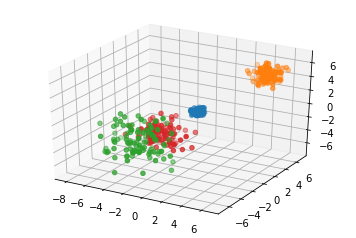

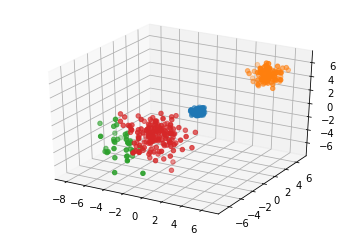

In [757]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = points[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = points[preds.flatten() == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()

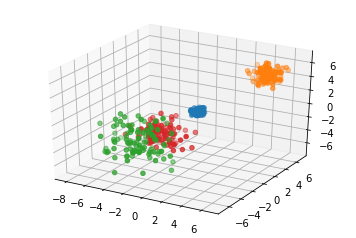

(400, 4)


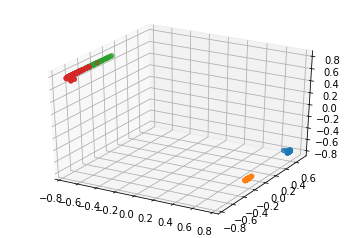

In [758]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = points[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()


preds = []
for i, p in enumerate(points):
    model.predict(p)
    preds.append(np.array(model.layers[-2].signal))
preds = np.array(preds)
print(preds.shape)
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = preds[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()

x = np.multiply(np.random.random_sample((300, inp_size)), np.random.random_integers(0, 5))
y = np.sum(x, axis = 1)
print(x[0].shape, y[0])

model.train(x, y, alpha = 0.003, batch_size= 50, epochs = 10)

for i, j in zip(x, y):
    p = model.predict(i)
    print(p, j, (p-j) * (p-j))

"""
errors = []
for i in range(len(x)):
    pred = model.predict(x[i])
    #print("Model, out_signal:", model.layers[-1].W.dot(np.append(x, 1)))
    print("pred:", pred)
    print("True_", y[i])
    if sum(pred) == 0:
        print(model.layers[-1].gradients)
    
    errors.append(np.sum(model.compute_gradient(x[i], y[i])))
    model.update_layers(alpha = 0.003)
    print()
    #print(model.layers[-1].gradients)
print(np.argmin(errors))
print(y[0])

plt.plot(errors)

plt.show()
"""

In [252]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive']
# Encode all points to the latent representation
def get_latent_space(model, points):
    
    latent_space = []
    
    for p in points:

        latent_space.append(model.predict(p))

    return np.array(latent_space)
    
# Get cluster centres   
def compute_clusters(labels, space):
    
    clusters = []
    num_clusters = len(np.unique(labels))

    if len(clusters) == 0:
        rang = np.arange(len(space))
        np.random.shuffle(rang)

        # Make each cluster the center of all generated points
        for lab in np.unique(labels):

            # Get the points belonging to the label
            labeled_points = space[labels == lab]

            # Take the mean of them and make that the cluster center
            clusters.append(np.mean(labeled_points, axis = 0))
    
    return clusters

def plot_clusters(clusters, colors):
    
    for cluster, color in zip(clusters, colors):
        plt.scatter(cluster[0], cluster[1], color = color)
        
    plt.show()
    
def plot_clasified_points(model, points, labels, colors):
    
    # Calculate latent representation
    latent_space = get_latent_space(model, points)
    
    for lab, color in zip(np.unique(labels), colors):

            # Get the points belonging to the label
        labeled_points = latent_space[labels == lab]

            # plot them
        plt.scatter(labeled_points.T[0], labeled_points.T[1], color = color)

    plt.show()

# Move clusters according to the separation formula
def separate_clusters(clusters, alpha = 5):
    
    moved_clusters = []

    for cluster in clusters:

        movement_sum = 0
        for other_cluster in clusters:

            #dist = alpha * 1/(cluster - other_cluster)
            dist = radial_basis_function(cluster, other_cluster, alpha)*5
            dist[dist == np.Inf] = 0
            movement_sum += dist

        #print(cluster, movement_sum)
        movement_sum = cluster + movement_sum

        moved_clusters.append(movement_sum)


    return np.array(moved_clusters)


In [58]:
# Create data points
size = 100
points = np.random.random_sample((size, 5))
labels = np.random.randint(3, size = size)

print(points[0])

[           0.390            0.282            0.220            0.589            0.232]


In [279]:
# Make the model
np.random.seed(0)
model = Model()
model.add(fullyConnected((4, 5), activation = sigmoid))
model.add(fullyConnected((3, 4), activation = sigmoid))
model.add(fullyConnected((2, 3), activation = sigmoid))

latent_space = get_latent_space(model, points)

clusters = compute_clusters(labels, latent_space)

plt.title("clusters")
plot_clusters(clusters, colors)

cluster_alpha = 0.000001
clusters = separate_clusters(clusters, alpha = cluster_alpha)

plt.title("clusters")
plot_clusters(clusters, colors)

plt.title("latent_space")
plot_clasified_points(model, points, labels, colors)


for i in range(5):
    
    
    clusters = compute_clusters(labels, latent_space)

    clusters = separate_clusters(clusters, alpha = cluster_alpha)
    
    # List of clusters such that the cluster corresponds with the labels
    clusters_ordered = [clusters[y] for y in labels]

    errors = model.train(points, clusters_ordered, epochs = 200, alpha = 0.0003, batch_size= 32, shuffle=False)
    #plot_clasified_points(model, points, labels, colors)
    latent_space = get_latent_space(model, points)

    
plt.title("clusters")
plot_clusters(clusters, colors)
plt.title("points")
plot_clasified_points(model, points, labels, colors)
    

ValueError: shapes (4,6) and (4,) not aligned: 6 (dim 1) != 4 (dim 0)

In [62]:
model = Model()
model.add(Connected_layer((3, 5), activation = tanh))
model.add(Connected_layer((2, 3), activation = tanh))
clusters = []
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive']

# Encode all points to the latent representation
latent_space = []
for p in points:
    
    latent_space.append(model.predict(p))
    
latent_space = np.array(latent_space)

# Get cluster centres (if they dont already exist)
num_clusters = len(np.unique(labels))
    
if len(clusters) == 0:
    rang = np.arange(len(latent_space))
    np.random.shuffle(rang)

    # Make each cluster the center of all generated points
    for lab, color in zip(np.unique(labels), colors):
        
        # Get the points belonging to the label
        labeled_points = latent_space[labels == lab]

        # Take the mean of them and make that the cluster center
        clusters.append(np.mean(labeled_points, axis = 0))
        
        # Scatter them for fun
        plt.scatter(labeled_points.T[0], labeled_points.T[1], color = color)

        
plt.show()
#for j in clusters:
#    plt.scatter(j[0], j[1])
    
#plt.show()
plt.title("initial cluster")
for cluster, color in zip(clusters, colors):
    plt.scatter(cluster[0], cluster[1], color = color)
plt.show()

# Move clusters according to the separation formula
alpha = 5
sums = []

for cluster in clusters:
    
    movement_sum = 0
    for other_cluster in clusters:
        
        dist = alpha * (cluster - other_cluster)
        dist[dist == np.Inf] = 0
        movement_sum += dist
        
    print(cluster, movement_sum)
    movement_sum = cluster + movement_sum
    
    sums.append(movement_sum)

    

clusters = np.array(sums)

plt.title("initial cluster")
for cluster, color in zip(clusters, colors):
    plt.scatter(cluster[0], cluster[1], color = color)
plt.show()

print(clusters)
# Show initial clustering
point_array = get_cluster_belonging(clusters, latent_space)
print("initial")
i = 0
for c, color in zip(point_array, colors):
    if len(c) > 0:
        plt.scatter(np.array(c).T[0], np.array(c).T[1], color = color)
plt.show()

print("####TRAINING####")
# Now, how to update the model?

clusters_ordered = [clusters[y] for y in labels]
for i in range(50):
    
    clusters = []
    # Make each cluster the center of all generated points
    for lab, color in zip(np.unique(labels), colors):
        
        # Get the points belonging to the label
        labeled_points = latent_space[labels == lab]

        # Take the mean of them and make that the cluster center
        clusters.append(np.mean(labeled_points, axis = 0))
        
        # Scatter them for fun
        #plt.scatter(labeled_points.T[0], labeled_points.T[1], color = color)
    
    sums = []

    for cluster in clusters:

        movement_sum = 0
        for other_cluster in clusters:

            dist = alpha * (cluster - other_cluster)
            dist[dist == np.Inf] = 0
            movement_sum += dist

        print(cluster, movement_sum)
        movement_sum = cluster + movement_sum

        sums.append(movement_sum)



    clusters = np.array(sums)
    
    for epochs in range(40):
        
        
        errors = model.batch_update(points, clusters_ordered, alpha = 0.03)
        
    #print(errors)
        #for x, y in zip(points, labels):

            

    latent_space = []
    # Show initial clustering
    for p in points:
    
        latent_space.append(model.predict(p))
    
    latent_space = np.array(latent_space)
    
    point_array = get_cluster_belonging(clusters, latent_space)
    print("Epoch", i)
    i = 0
    for c, color in zip(point_array, colors):
        if len(c) > 0:
            plt.scatter(np.array(c).T[0], np.array(c).T[1], color = color)
    plt.show()
    

    


NameError: name 'Connected_layer' is not defined

Latent Space:


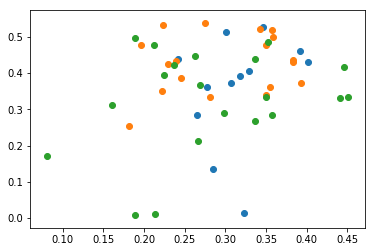

In [172]:
print("Latent Space:")
plot_clasified_points(model, points, labels, colors)

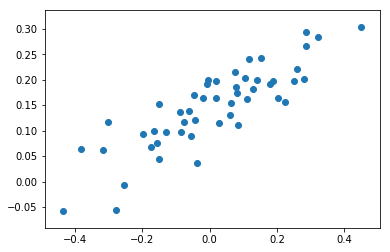

In [116]:
plt.scatter(np.array(latent_space).T[0], np.array(latent_space).T[1])
plt.show()

In [117]:
def one_hot_encode(x, num_classes = 6):
    ret = []
    for i in x:
        arr = [0 for i in range(num_classes)]
        arr[i] = 1
        ret.append(np.array(arr))
    ret = np.array(ret)
    return ret
encoded_labels = one_hot_encode(labels, num_classes = 3)

In [63]:
encoded_labels

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

In [165]:
model = Model()
model.add(Connected_layer((4, 5), activation = tanh))
#model.add(Connected_layer((10, 10), activation = tanh))
model.add(Connected_layer((3, 4), activation = tanh))

model.train(points, encoded_labels, epochs=300, alpha = 0.007, batch_size= 16, shuffle=True)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100

In [166]:
acc = 0
for p, l in zip(points, labels):

    pred = model.predict(p)
    
    if np.argmax(pred) == l: 
        acc += 1

        
print(acc/ len(points))

0.46


In [278]:
def d(x):
    return x + 1

list(map(d, [1]))

[2]

In [233]:
a = [0, 1, 2, 3]
b = [7, 7, 7, 7]
np.where(np.array(a) > 2, b, 0)

array([0, 0, 0, 7])

In [315]:
len(np.array([1]))

1